# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [1]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('./data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [2]:
# Install keras

In [3]:
# Import the tools we will need from keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:

# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [5]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
# What do these sequences look like?
X_train_seq[0]

[382, 237, 105, 88]

In [7]:
X_test_seq[0]

[33, 257, 585, 15, 10, 76, 56, 38]

In [8]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded=pad_sequences(X_train_seq, 50)
X_test_seq_padded=pad_sequences(X_test_seq, 50)

In [9]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 382, 237, 105,  88], dtype=int32)

### Build Model

In [10]:
# Import the tools needed from keras and define functions to calculate recall and precision
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [11]:
# Construct a simple RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32,  dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          255264    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 264,673
Trainable params: 264,673
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [13]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 4s 19ms/step - loss: 0.4766 - accuracy: 0.8293 - precision_m: 0.1673 - recall_m: 0.1890 - val_loss: 0.0664 - val_accuracy: 0.9812 - val_precision_m: 0.9905 - val_recall_m: 0.8854
Epoch 2/10
140/140 [==============================] - 2s 13ms/step - loss: 0.0556 - accuracy: 0.9850 - precision_m: 0.9718 - recall_m: 0.9108 - val_loss: 0.0404 - val_accuracy: 0.9857 - val_precision_m: 0.9514 - val_recall_m: 0.9483
Epoch 3/10
140/140 [==============================] - 2s 13ms/step - loss: 0.0198 - accuracy: 0.9948 - precision_m: 0.9794 - recall_m: 0.9582 - val_loss: 0.0358 - val_accuracy: 0.9830 - val_precision_m: 0.9481 - val_recall_m: 0.9255
Epoch 4/10
140/140 [==============================] - 2s 13ms/step - loss: 0.0066 - accuracy: 0.9991 - precision_m: 0.9771 - recall_m: 0.9724 - val_loss: 0.0354 - val_accuracy: 0.9901 - val_precision_m: 0.9562 - val_recall_m: 0.9812
Epoch 5/10
140/140 [==============================] - 2s 13ms/step -

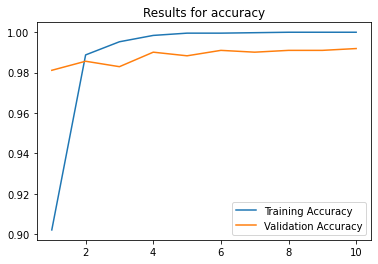

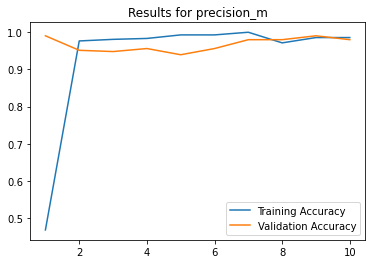

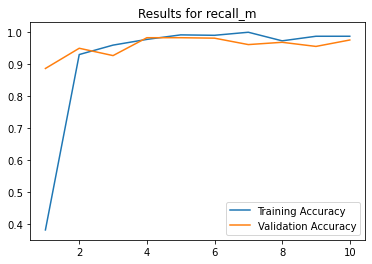

In [14]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()